# Basic CNN in Keras

* Keras Cheat Sheet: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf

# Setup: Load modules

In [1]:
#import os; os.chdir("/notebooks/test_scripts")

# System 
import os
import sys 
import shutil
from time import time

# Simple CNN model for CIFAR-10
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import model_from_json

from keras import backend as K

# Datasets
from keras.datasets import cifar10

# Images 
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Debugging 
import resource
import pprint
from keras.callbacks import TensorBoard
from tensorflow.python import debug as tf_debug

Using TensorFlow backend.


# Parameters: General

In [2]:
# For pprint 
pp = pprint.PrettyPrinter(indent=2)

# Set image dimension ordering
# NOTE: "tf" assumes (rows, cols, channels); "th" assumes (channels, rows, cols)
K.set_image_dim_ordering('tf')

# Initialize TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()) )

# Fix random seed
seed = 1
np.random.seed(seed)

# Data: Load data

In [3]:
# Data file 
cifar10_file = 'cifar10.npz'

# Save to file
# NOTE: Data loaded through pickle caused issues  
if not os.path.isfile(cifar10_file):
    # Downloaded from: http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    np.savez(cifar10_file, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
else: 
    npz = np.load(cifar10_file)
    (x_train, y_train), (x_test, y_test) = ((npz['x_train'], npz['y_train']), (npz['x_test'], npz['y_test']))
        
num_train, img_channels, img_rows, img_cols = x_train.shape
num_test, _, _, _ =  x_train.shape
num_classes = len(np.unique(y_train))

# Data: Visualize training data

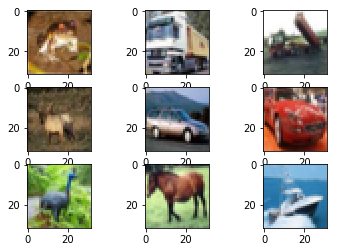

In [4]:
# Create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(Image.fromarray(x_train[i], 'RGB'))
    
# Show the plot
plt.show()

# Data: Normalize

In [5]:
# Data file 
cifar10_normalized_file = 'cifar10_normalized.npz'

# Save to file
if not os.path.isfile(cifar10_normalized_file):
    # Normalize inputs from 0-255 to 0.0-1.0
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    np.savez(cifar10_normalized_file, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
else: 
    npz = np.load(cifar10_normalized_file)
    (x_train, y_train), (x_test, y_test) = ((npz['x_train'], npz['y_train']), (npz['x_test'], npz['y_test']))

# Data: Encode outputs

In [6]:
# One hot encode outputs
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

# Parameters: Model

In [7]:
input_shape = (32, 32, 3)
kernel_size = (3, 3)
pool_size = (2, 2)

# Model: Check shapes

In [8]:
assert x_train.shape[1:4]==input_shape, "ERROR: Shape"

# Model: Create

https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=kernel_size, name='conv2d_1', input_shape=input_shape, padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2, name='dropout_1'))
model.add(Conv2D(32, kernel_size=kernel_size, name='conv2d_2', activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=pool_size, name='max_pooling2d_1'))
model.add(Flatten(name='flatten_1'))
model.add(Dense(512, name='dense_1', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5, name='dropout_2'))
model.add(Dense(num_classes, name='dense_2', activation='softmax'))

# Model: Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

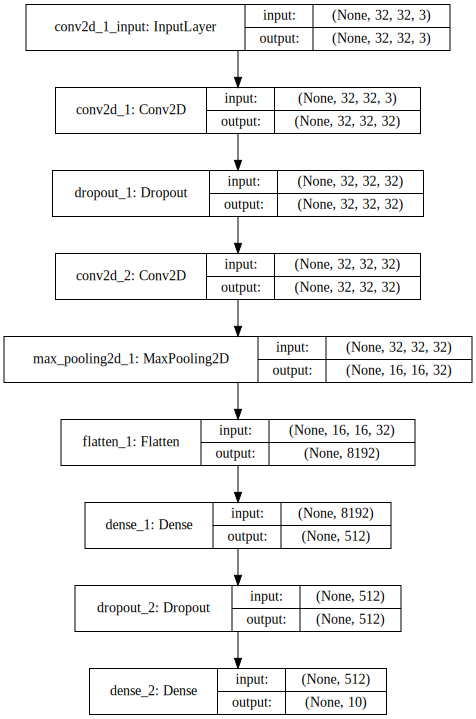

In [10]:
print(model.summary())
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# Parameters: Fit

In [11]:
epochs = 2
batch_size = 64

# Parameters: Optimization

In [12]:
lrate = 0.01
decay = lrate/epochs

# Model: Compile

In [13]:
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Model: Fit

In [ ]:
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=1, 
          callbacks=[tensorboard])

# Model: Evaluate

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Model: Serialize

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [ ]:
if os.path.isdir("./output"):
    shutil.rmtree("./output")

os.makedirs("./output")

# Serialize model to JSON
model_json = model.to_json()
with open("output/model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("output/model.h5")
print("Saved model")

# Model: Load

In [14]:
# Load json and create model
json_file = open('output/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("output/model.h5")
print("Loaded model")
 
# Evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

scores = loaded_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Loaded model
Accuracy: 50.05%


# Visualize: Layers; Feature (aka Activation) Maps 

Visualize activation maps also known as feature maps. 

In [207]:
from utils.read_activations import get_activations, display_activations
from utils.visualize_activations import * 

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)

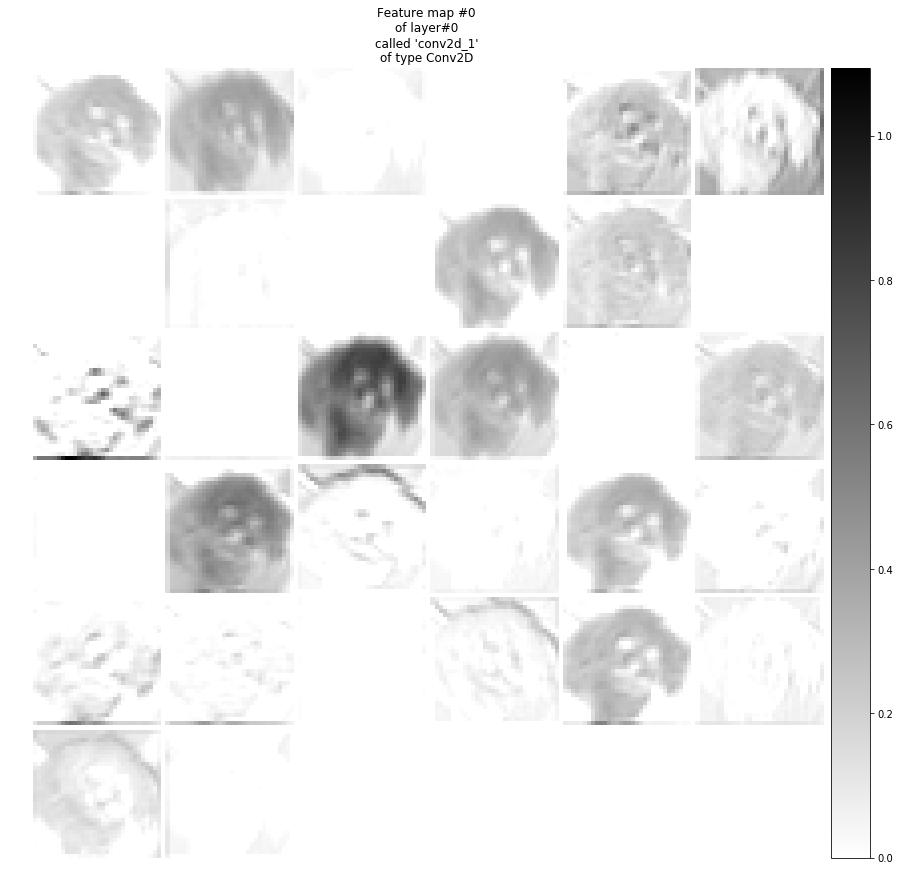

In [212]:
i = 1000
image = x_test[i:(i+1)]
plot_feature_map(loaded_model, X=image, layer_id=0, n_columns=1, n=40)

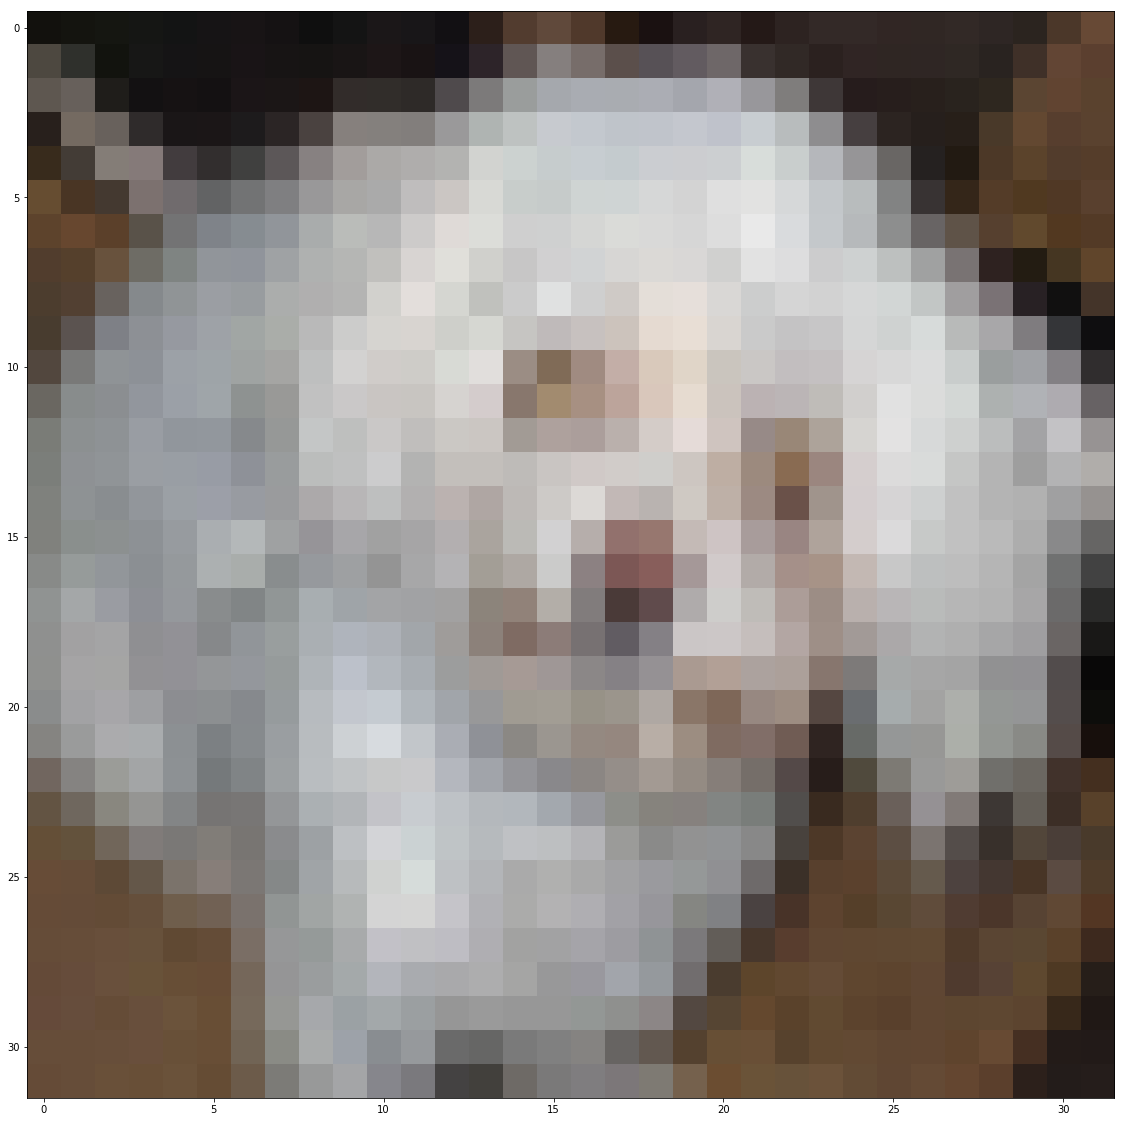

In [211]:
plt.imshow(image[0])